In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Feature_Selection.ipynb


In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


In [3]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
df_pay['JoinMonth'] = df_pay['UserJoinedDate'].dt.month

payment = df_pay[['UserID', 'UserJoinedDate', 'gapday']]
payment.shape

(265308, 3)

In [4]:
df_pay

,UserID,UserJoinedDate,firstpay,firstPaymentType,gapday,Amount,TransactionNo,avgValue,JoinMonth
0,ec89feb8-1a49-4f9f-8000-7190bcf3fffe,2022-05-11 21:12:49,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,5
1,6d5d2eb9-92b5-451e-8001-2dedda19c69a,2022-05-28 13:42:41,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,5
2,10f73f6c-48c1-490b-8001-b4144412f5ac,2022-05-14 01:14:16,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,5
3,a7faa4ad-252b-4045-8001-e93da29de108,2022-05-18 18:58:13,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,5
4,e799503f-c58c-4816-8002-86b1169cbb63,2022-05-11 20:59:07,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,5
...,...,...,...,...,...,...,...,...,...
265303,8693b3ec-52fc-4d77-bfee-6e0b7fe7ca08,2023-04-01 22:16:16,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,4
265304,0fce2c90-2f33-4dc2-bff0-17cdab43c1f9,2023-04-17 21:06:28,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,4
265305,0f25547e-8e7b-4d05-bff1-1aed60a1d2d4,2023-04-19 19:40:53,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,4
265306,1de73431-9f8e-4a62-bff1-4dd08fa0f50c,2023-04-15 18:56:19,1970-01-01 08:00:00+08:00,NaN,NaN,0,0,0.0,4


In [5]:
detail = pd.read_csv('Engagement_detail_learn_updated.csv')
detail['InteractionLearn'] = detail['UsageTime'] * detail['Records']

detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506702 entries, 0 to 1506701
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   EventDate                  1506702 non-null  object 
 1   nth_day_from_registration  1506702 non-null  int64  
 2   UserID                     1506702 non-null  object 
 3   SubjectName                1506702 non-null  object 
 4   IsCompleted                1506702 non-null  int64  
 5   UsageTime                  1506702 non-null  float64
 6   Records                    1506702 non-null  int64  
 7   InteractionLearn           1506702 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ MB


In [6]:
detail = pd.merge(left=detail,
                  right=payment,
                  how='left',
                  on='UserID')
detail.shape

(1506702, 10)

In [7]:
firstday_learn = pd.DataFrame(detail.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday_learn.columns = ['UserID', 'MinFirstDay']

firstday_learn['ZeroDay'] = firstday_learn['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday_learn.shape

(153340, 3)

In [8]:
detail = pd.merge(left=detail,
                  right=firstday_learn,
                  how='left',
                  on='UserID')

detail.loc[detail['gapday'].isnull(), 'gapday'] = 'no_pay'
detail.shape

(1506702, 12)

In [9]:
def DetailBasedNthDay(dataframe, nthday=1):
    pay = dataframe.loc[dataframe['gapday'] != 'no_pay']
    
    mask0 = pay['ZeroDay'] == 'zero'
    mask1 = pay['nth_day_from_registration'] <= nthday
    df0 = pay[mask0 & mask1]
    
    df0['CutoffDay'] = df0['MinFirstDay'] + nthday
    df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
    df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']
    
    mask2 = pay['ZeroDay'] != 'zero'
    others = pay[mask2]
    others['CutoffDay'] = others['MinFirstDay'] + nthday
    
    mask3 = others['nth_day_from_registration'] <= others['CutoffDay']
    df1 = others[mask3]
    df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
    df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']
    
    purchaser = pd.concat([df0, df1], ignore_index=True)
    
    free = dataframe.loc[dataframe['gapday'] == 'no_pay']
    f0 = free['ZeroDay'] == 'zero'
    f1 = free['nth_day_from_registration'] <= nthday
    free0 = free[f0 & f1]
    
    free0['CutoffDay'] = free0['MinFirstDay'] + nthday
    free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
    free0['ScaleGapday'] = free0['gapday']
    
    non0 = free.loc[free['ZeroDay'] != 'zero']
    non0['CutoffDay'] = non0['MinFirstDay'] + nthday
    f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']
    free1 = non0[f3]
    free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
    free1['ScaleGapday'] = free1['gapday']
    
    non_purchaser = pd.concat([free0, free1], ignore_index=True)
    
    data = pd.concat([purchaser, non_purchaser], ignore_index=True)
    
    return data

In [10]:
learn_detail = DetailBasedNthDay(detail, nthday=1)

In [11]:
content_learn = learn_detail.pivot_table(index = 'UserID',
                                         columns = 'SubjectName',
                                         values = ['IsCompleted', 'UsageTime', 'Records', 'InteractionLearn'],
                                         aggfunc = np.sum).reset_index()

cols = ['UserID',
        'InteractionEnglish', 'InteractionMath', 'InteractionPhonics', 'InteractionVietnamese',
        'IsCompletedEnglish', 'IsCompletedMath','IsCompletedPhonics', 'IsCompletedVietnamese',
        'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
        'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

content_learn.columns = cols

for col in content_learn.columns[1:]:
    content_learn.loc[content_learn[col].isnull(), col] = 0
    
content_learn.shape

(153340, 17)

In [12]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse_hour'] = engage['firstuse'].dt.hour
engage['lastuse_hour'] = engage['lastuse'].dt.hour
engage['lastuse_day'] = engage['lastuse'].dt.day
engage['lastuse_dayofweek'] = engage['lastuse'].dt.dayofweek
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 17)

In [13]:
engage = pd.merge(left=engage,
                  right=payment[['UserID', 'gapday']],
                  on='UserID',
                  how='left')
engage.shape

(1638631, 18)

In [14]:
brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [15]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [16]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(1638631, 21)

In [17]:
action = DetailBasedNthDay(engage, nthday=1)

In [18]:
action.shape

(336340, 24)

In [19]:
action.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336340 entries, 0 to 336339
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   EventDate                  336340 non-null  object        
 1   UserID                     336340 non-null  object        
 2   ActionType                 336340 non-null  object        
 3   UserJoinedDate             336340 non-null  datetime64[ns]
 4   nth_day_from_registration  336340 non-null  int64         
 5   open_time                  336340 non-null  int64         
 6   payment_screen_time        336340 non-null  int64         
 7   DeviceBrand                305289 non-null  object        
 8   UsageTime                  336340 non-null  float64       
 9   Records                    336340 non-null  int64         
 10  lastuse                    336340 non-null  datetime64[ns]
 11  firstuse                   336340 non-null  datetime

In [20]:
Recency = lambda x: 2 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

Mode_firstuse_hour = lambda x: x.mode()[0]
Mode_lastuse_day = lambda x: x.mode()[0]
Mode_lastuse_hour = lambda x: x.mode()[0]
Mode_lastuse_dayofweek = lambda x: x.mode()[0]
Purchase = lambda x: max(x)

active = action.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record,
                                     'firstuse_hour': Mode_firstuse_hour,
                                     'lastuse_hour': Mode_lastuse_hour,
                                     'lastuse_day': Mode_lastuse_day,
                                     'lastuse_dayofweek': Mode_lastuse_dayofweek,
                                     'ScaleGapday': Purchase}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay', 'ModeDayofweek',
        'ScaleGapday']

active.columns = cols

In [21]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = action.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [22]:
action['Counting'] = [1] * action.shape[0]

brand = action.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [23]:
content_sum = action.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [24]:
Number_of_device = lambda x: len(x.unique())

demo = action.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [28]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(content_learn.shape)
print(demo.shape)
print(demographics.shape)

(163040, 11)
(163040, 7)
(163040, 4)
(163040, 4)
(153340, 17)
(163040, 2)
(173193, 5)


In [29]:
data_list = [active, demographics, demo, brand, content_learn, content_sum, active_median, 
             df_pay[['UserID', 'firstPaymentType', 'JoinMonth','gapday']]]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 47)

In [30]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 47)

In [31]:
data = final.copy()

In [32]:
learning_detail = ['InteractionEnglish', 'InteractionMath','InteractionPhonics', 'InteractionVietnamese', 
                   'IsCompletedEnglish', 'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
                   'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
                   'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

for col in learning_detail:
    data.loc[data[col].isnull(), col] = 0

In [33]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']
data['InteractionGeneral'] = data['TotalUsageTime'] * data['TotalRecords']
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

In [40]:
data.loc[data['ScaleGapday'] == 'no_pay', 'ScaleGapday'] = np.nan

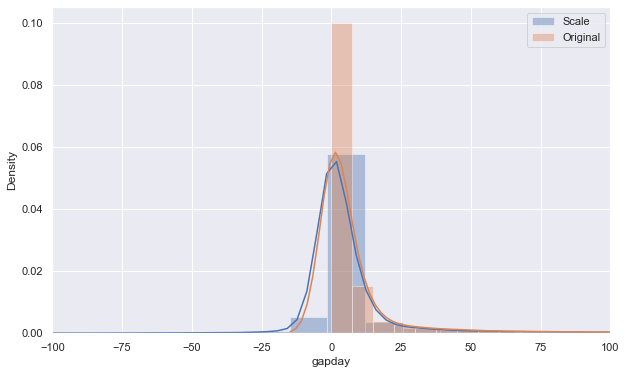

In [45]:
plt.figure(figsize=(10, 6))
sb.distplot(data['ScaleGapday'], label = 'Scale')
sb.distplot(data['gapday'], label='Original')
plt.legend()
plt.xlim([-100, 100]);

In [46]:
data['Label'] = data['ScaleGapday'].map(lambda x: 1 if x <= 31 else 0)

In [47]:
data['Label'].value_counts()

0    148521
1     10460
Name: Label, dtype: int64

In [48]:
data1 = data.copy()

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  int64  
 6   ModeFirstHour             158981 non-null  int64  
 7   ModeLastHour              158981 non-null  int64  
 8   ModeLastDay               158981 non-null  int64  
 9   ModeDayofweek             158981 non-null  int64  
 10  ScaleGapday               11223 non-null   object 
 11  TotalChild                158981 non-null  float64
 12  MedianChildAge            158981 non-null  float64
 13  No.Female                 158981 non-null  f

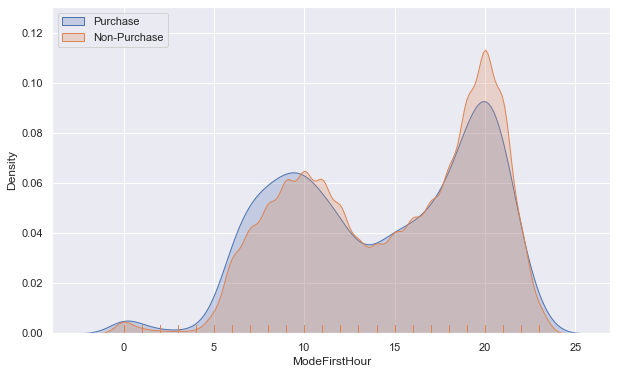

In [50]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

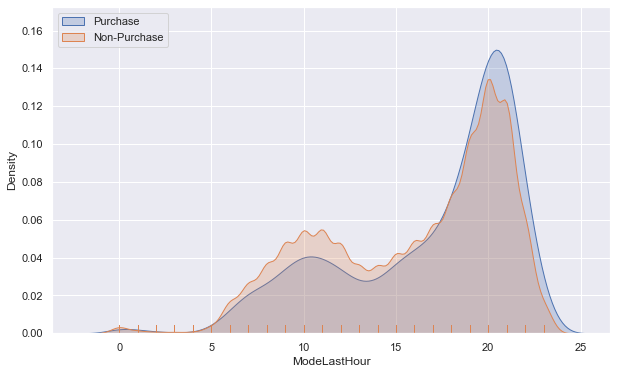

In [51]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeLastHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeLastHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

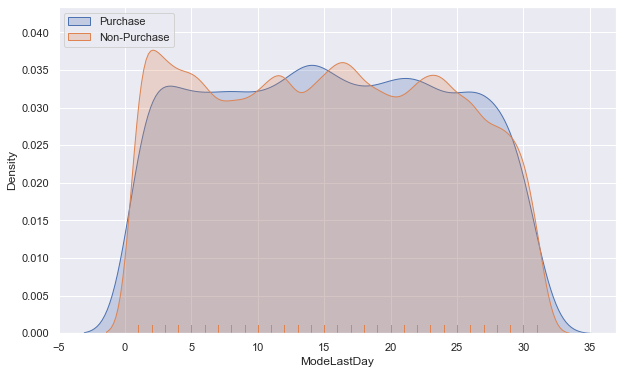

In [52]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeLastDay'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeLastDay'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

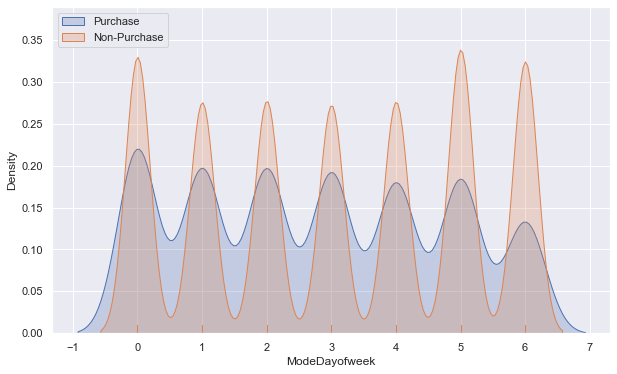

In [53]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeDayofweek'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeDayofweek'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

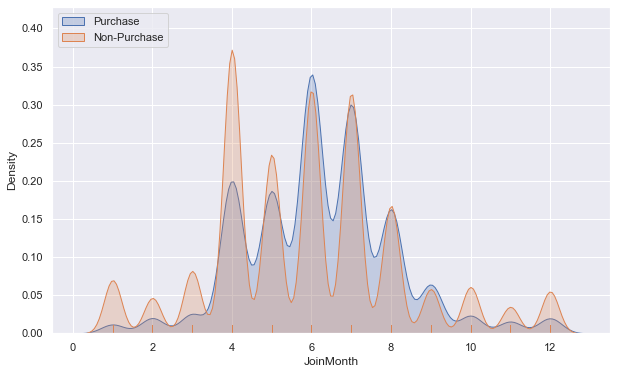

In [54]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['JoinMonth'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['JoinMonth'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

In [55]:
excludes = ['firstPaymentType', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 'TotalChild', 
            'MedianChildAge', 'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
            'SmallBrand', 'Label', 'gapday', 'JoinMonth', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay',
            'ModeDayofweek', 'ScaleGapday']

for col in data.columns[1:]:
    if col not in excludes:
        if data[col].min() == 0:
            data[col] = data[col] + 1
            data[col] = np.log(data[col])
        else:
            data[col] = np.log(data[col])

----- TotalUsageTime -----
count    158981.000000
mean          2.455485
std           1.183931
min           0.000000
25%           1.515127
50%           2.537657
75%           3.350956
max           7.078611
Name: TotalUsageTime, dtype: float64
* Variance: 1.4016935864129958
* Median: 2.5376572151735295
* Skewness: -0.03920504402125023
* Kurtosis: -0.8127449892550369
* Percentage of outliers: 5.6610538366219865e-05
* Number of missing value: 0


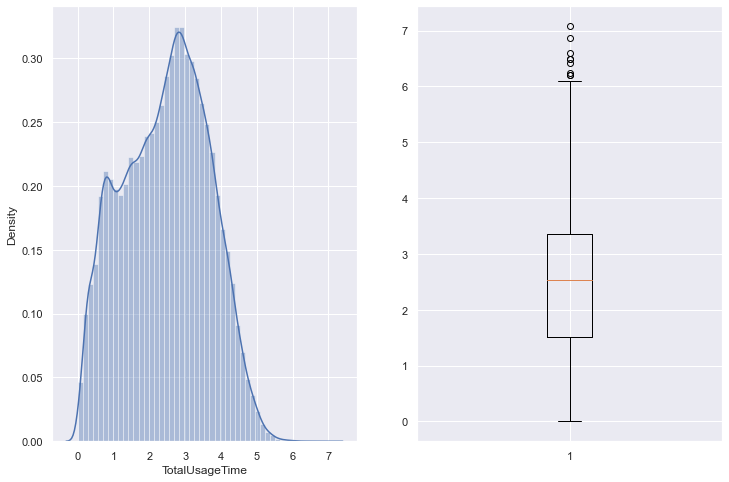


----- TotalRecords -----
count    158981.000000
mean          2.351732
std           1.234208
min           0.000000
25%           1.386294
50%           2.484907
75%           3.295837
max           6.311735
Name: TotalRecords, dtype: float64
* Variance: 1.5232686082727207
* Median: 2.4849066497880004
* Skewness: -0.2509948882162156
* Kurtosis: -0.6986479320297221
* Percentage of outliers: 6.290059818468873e-06
* Number of missing value: 0


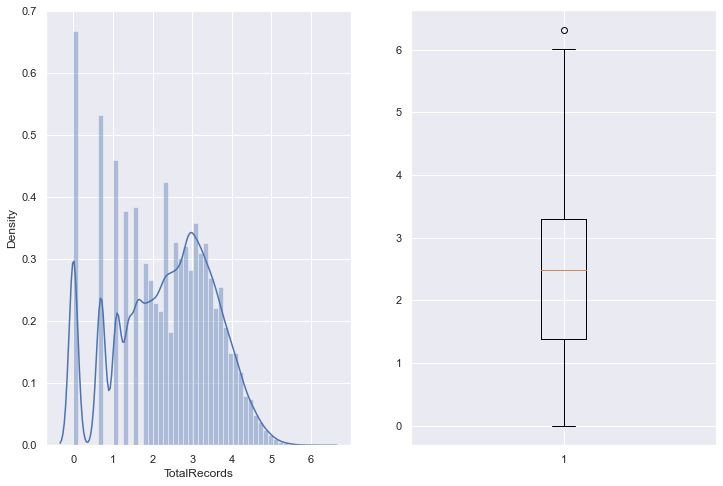


----- InteractionEnglish -----
count    158981.000000
mean          1.952449
std           2.361872
min           0.000000
25%           0.000000
50%           0.576613
75%           4.070564
max          11.664985
Name: InteractionEnglish, dtype: float64
* Variance: 5.578440529181716
* Median: 0.5766133643039938
* Skewness: 0.7962279242761756
* Kurtosis: -0.798645957041177
* Percentage of outliers: 7.548071782162648e-05
* Number of missing value: 0


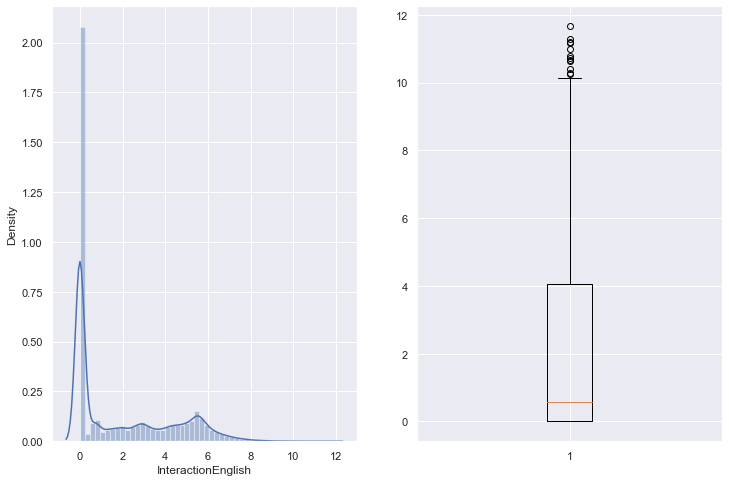


----- InteractionMath -----
count    158981.000000
mean          0.065885
std           0.538871
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.701298
Name: InteractionMath, dtype: float64
* Variance: 0.29038228056037735
* Median: 0.0
* Skewness: 9.704494398732523
* Kurtosis: 102.74335602406661
* Percentage of outliers: 0.0238456167718155
* Number of missing value: 0


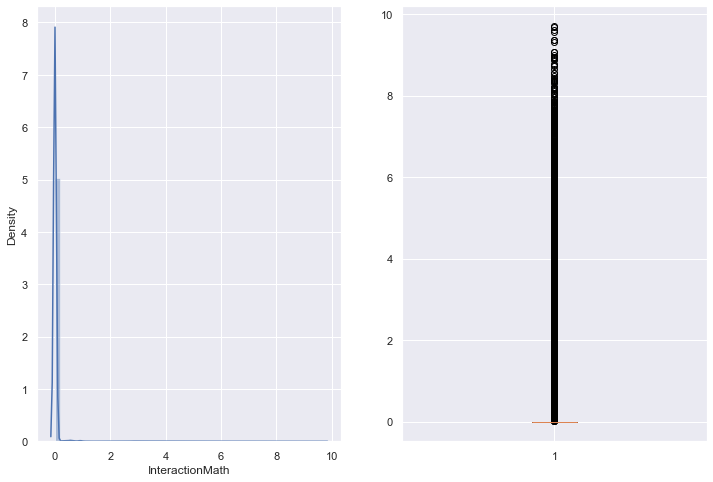


----- InteractionPhonics -----
count    158981.000000
mean          0.070404
std           0.532213
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.062838
Name: InteractionPhonics, dtype: float64
* Variance: 0.28325111262231983
* Median: 0.0
* Skewness: 8.930838206188215
* Kurtosis: 86.93068756958027
* Percentage of outliers: 0.02497153747932143
* Number of missing value: 0


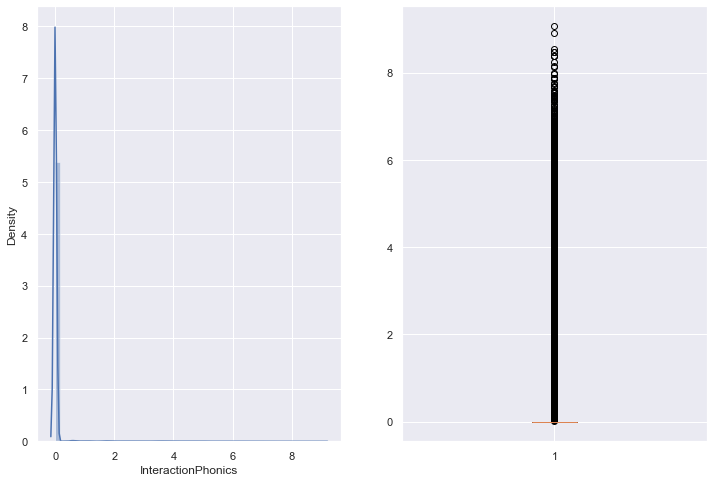


----- InteractionVietnamese -----
count    158981.000000
mean          2.077620
std           2.499071
min           0.000000
25%           0.000000
50%           0.641854
75%           4.143928
max          11.397071
Name: InteractionVietnamese, dtype: float64
* Variance: 6.245357188082897
* Median: 0.6418538861723947
* Skewness: 0.8490616587426203
* Kurtosis: -0.6481243559272105
* Percentage of outliers: 0.0001195111365509086
* Number of missing value: 0


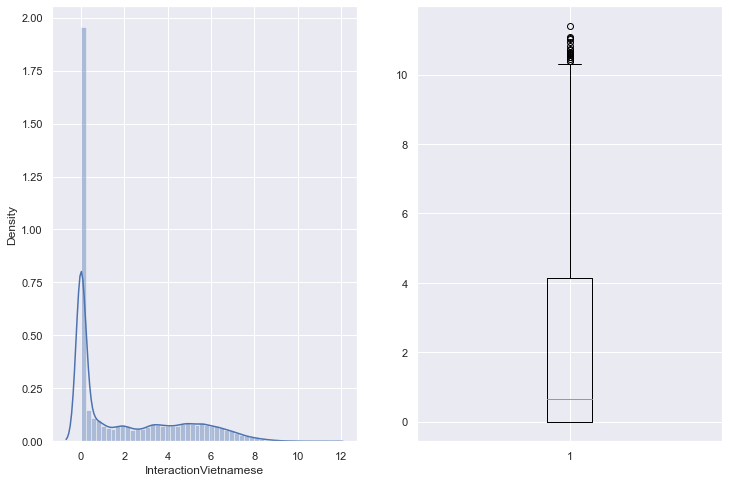


----- IsCompletedEnglish -----
count    158981.000000
mean          0.401165
std           0.416745
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.098612
Name: IsCompletedEnglish, dtype: float64
* Variance: 0.1736765256888231
* Median: 0.6931471805599453
* Skewness: 0.2828658364329821
* Kurtosis: -1.487835402351314
* Percentage of outliers: 0.0
* Number of missing value: 0


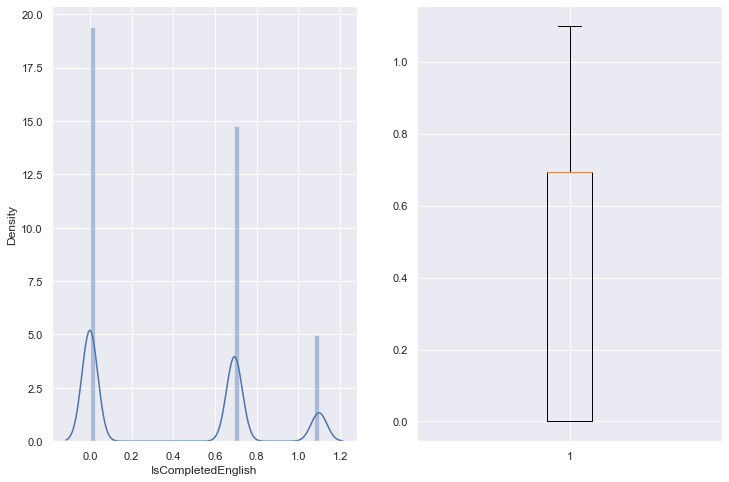


----- IsCompletedMath -----
count    158981.000000
mean          0.016569
std           0.113442
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.098612
Name: IsCompletedMath, dtype: float64
* Variance: 0.012869069451352041
* Median: 0.0
* Skewness: 7.047545796845342
* Kurtosis: 50.602018910089086
* Percentage of outliers: 0.02172586661299149
* Number of missing value: 0


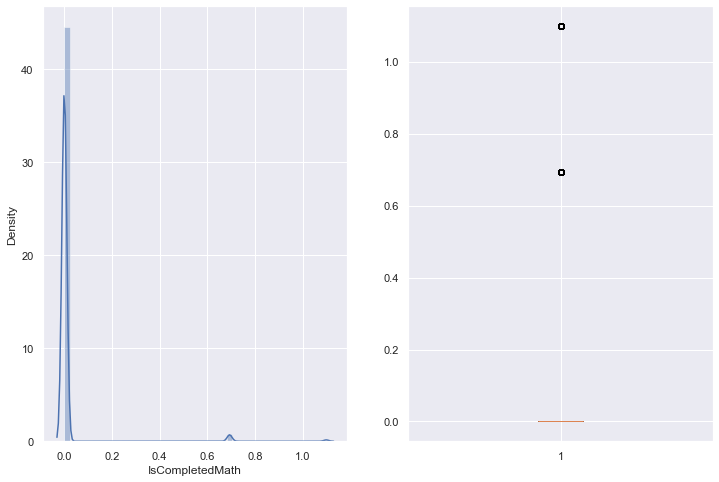


----- IsCompletedPhonics -----
count    158981.000000
mean          0.016964
std           0.113886
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.098612
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.012970080329985237
* Median: 0.0
* Skewness: 6.886174280594748
* Kurtosis: 48.17115465754807
* Percentage of outliers: 0.02250583403048163
* Number of missing value: 0


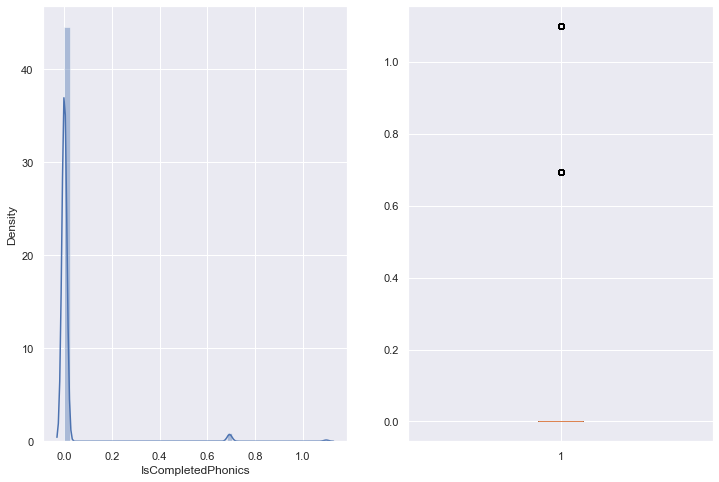


----- IsCompletedVietnamese -----
count    158981.000000
mean          0.414726
std           0.420230
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.098612
Name: IsCompletedVietnamese, dtype: float64
* Variance: 0.176593106202271
* Median: 0.6931471805599453
* Skewness: 0.23893900944255622
* Kurtosis: -1.5069244824378474
* Percentage of outliers: 0.0
* Number of missing value: 0


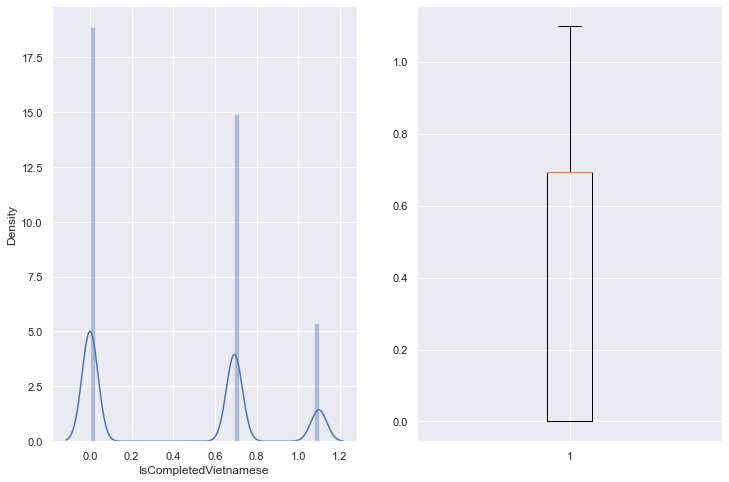


----- RecordEnglish -----
count    158981.000000
mean          1.208349
std           1.347555
min           0.000000
25%           0.000000
50%           0.693147
75%           2.397895
max           5.799093
Name: RecordEnglish, dtype: float64
* Variance: 1.8159042242367502
* Median: 0.6931471805599453
* Skewness: 0.5930429632035079
* Kurtosis: -1.0805899943001005
* Percentage of outliers: 0.0
* Number of missing value: 0


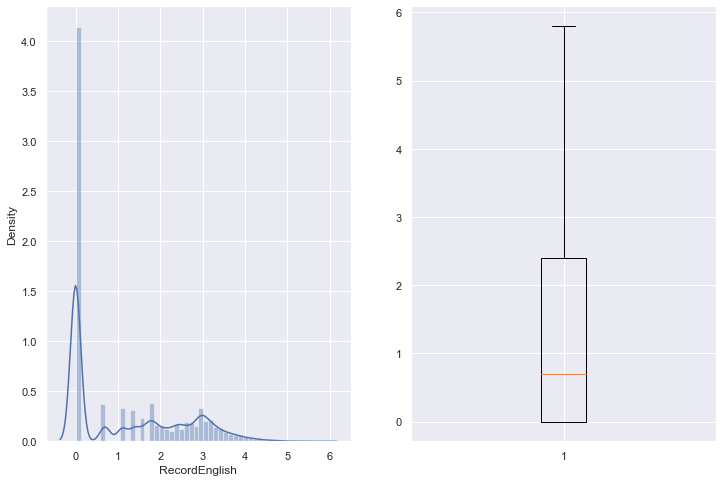


----- RecordMath -----
count    158981.000000
mean          0.043562
std           0.312328
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.762174
Name: RecordMath, dtype: float64
* Variance: 0.09754872554491147
* Median: 0.0
* Skewness: 8.255435604923365
* Kurtosis: 74.07902194844964
* Percentage of outliers: 0.023864486951270907
* Number of missing value: 0


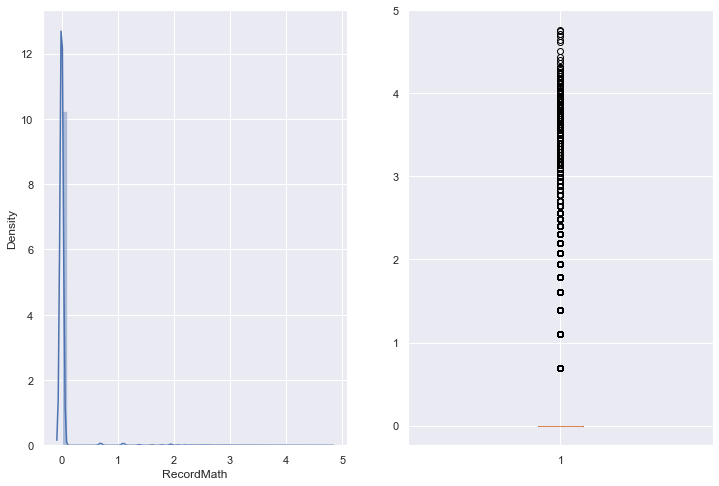


----- RecordPhonics -----
count    158981.000000
mean          0.044807
std           0.310490
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.017280
Name: RecordPhonics, dtype: float64
* Variance: 0.09640418845923887
* Median: 0.0
* Skewness: 7.925653249186303
* Kurtosis: 68.19092408246453
* Percentage of outliers: 0.025002987778413772
* Number of missing value: 0


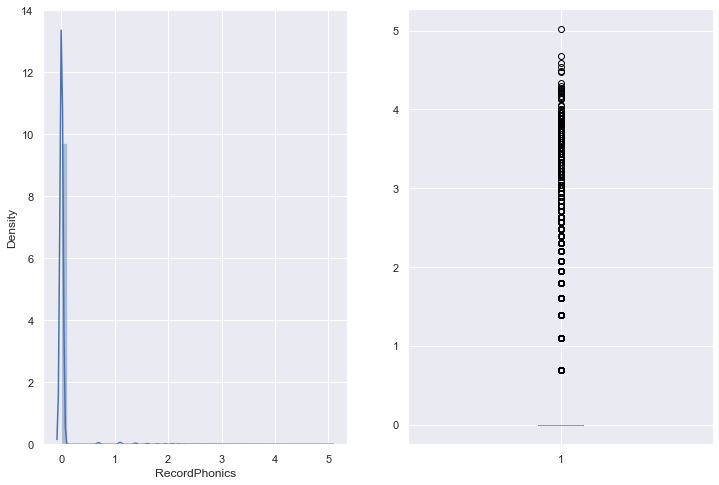


----- RecordVietnamese -----
count    158981.000000
mean          1.242317
std           1.351693
min           0.000000
25%           0.000000
50%           0.693147
75%           2.302585
max           6.054439
Name: RecordVietnamese, dtype: float64
* Variance: 1.8270743629604302
* Median: 0.6931471805599453
* Skewness: 0.6807343751612923
* Kurtosis: -0.8137056995419538
* Percentage of outliers: 4.4030418729282114e-05
* Number of missing value: 0


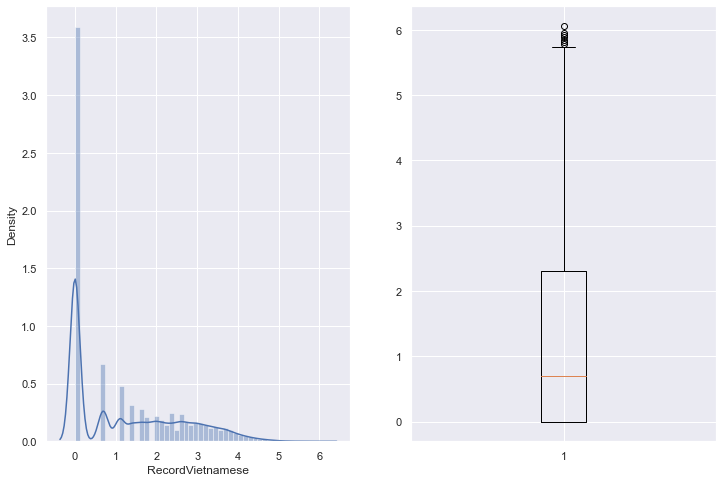


----- UsageTimeEnglish -----
count    158981.000000
mean          1.061530
std           1.232506
min           0.000000
25%           0.000000
50%           0.559616
75%           2.125848
max           7.019967
Name: UsageTimeEnglish, dtype: float64
* Variance: 1.5190709206804043
* Median: 0.5596157879354227
* Skewness: 0.7460162249929259
* Kurtosis: -0.7519557015012426
* Percentage of outliers: 0.00020757197400947283
* Number of missing value: 0


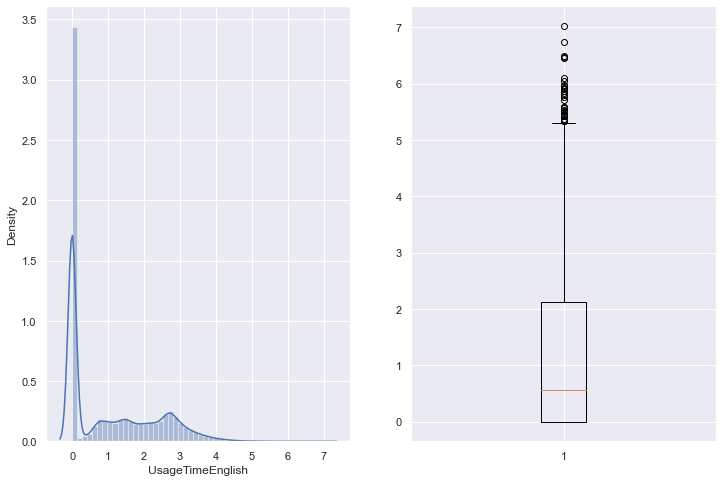


----- UsageTimeMath -----
count    158981.000000
mean          0.037718
std           0.297399
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.889902
Name: UsageTimeMath, dtype: float64
* Variance: 0.08844629358899095
* Median: 0.0
* Skewness: 9.531589015916481
* Kurtosis: 100.75754895420282
* Percentage of outliers: 0.0238456167718155
* Number of missing value: 0


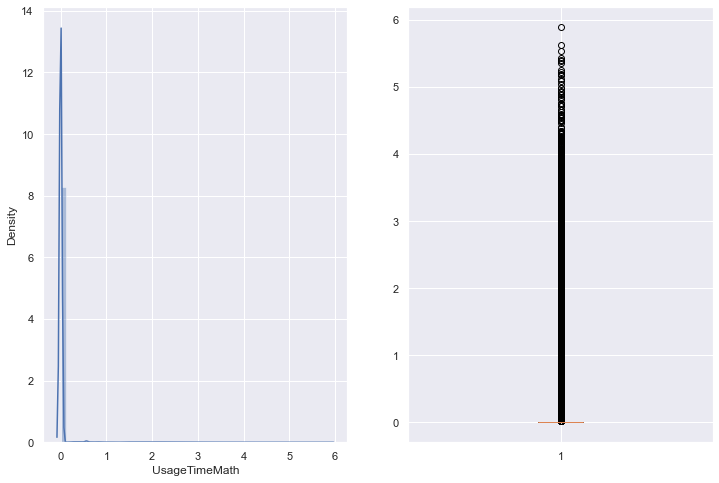


----- UsageTimePhonics -----
count    158981.000000
mean          0.042845
std           0.304186
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.853981
Name: UsageTimePhonics, dtype: float64
* Variance: 0.09252886314951227
* Median: 0.0
* Skewness: 8.153655472407866
* Kurtosis: 72.13837083173843
* Percentage of outliers: 0.02497153747932143
* Number of missing value: 0


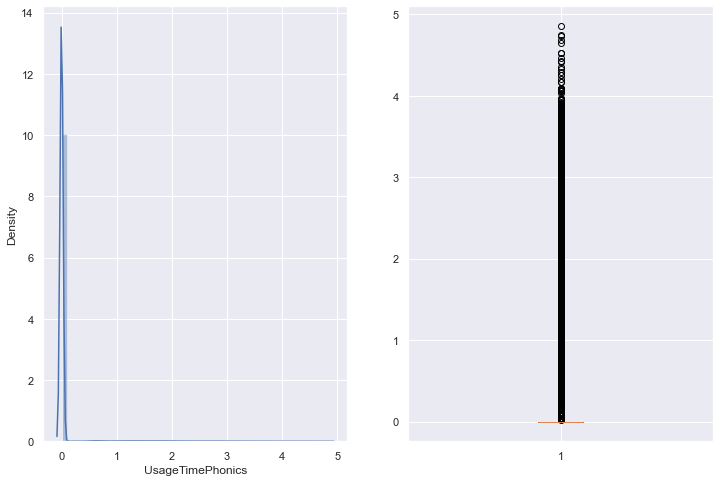


----- UsageTimeVietnamese -----
count    158981.000000
mean          1.164994
std           1.324640
min           0.000000
25%           0.000000
50%           0.587787
75%           2.288486
max           6.220352
Name: UsageTimeVietnamese, dtype: float64
* Variance: 1.7546711547039369
* Median: 0.587786664902119
* Skewness: 0.737909369879308
* Kurtosis: -0.7958108879075345
* Percentage of outliers: 3.774035891081324e-05
* Number of missing value: 0


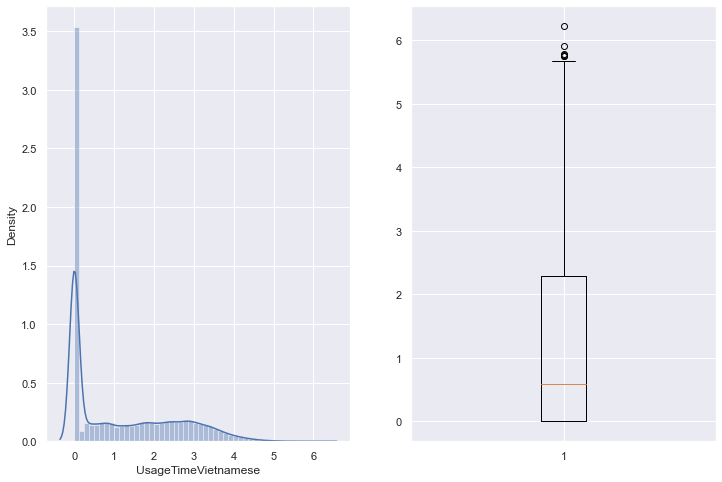


----- RecordDiscovery -----
count    158981.000000
mean          0.498411
std           0.784418
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.087596
Name: RecordDiscovery, dtype: float64
* Variance: 0.6153117988770085
* Median: 0.0
* Skewness: 1.4161906784193077
* Kurtosis: 0.89526721428828
* Percentage of outliers: 0.1162780458042156
* Number of missing value: 0


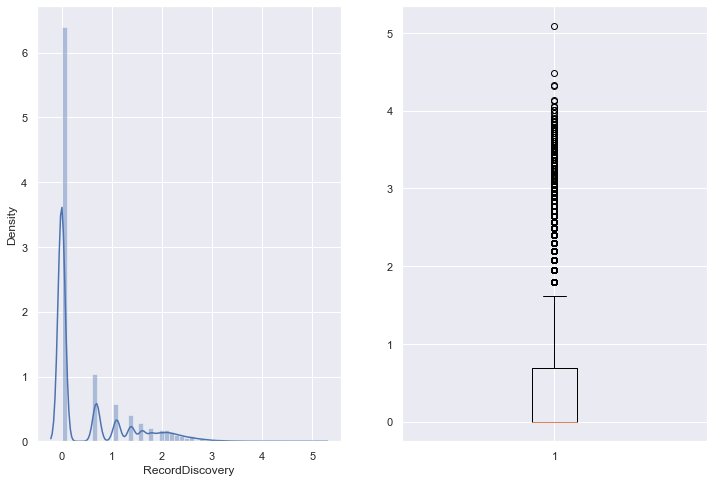


----- RecordEntertainment -----
count    158981.000000
mean          0.579802
std           0.907028
min           0.000000
25%           0.000000
50%           0.000000
75%           1.098612
max           5.393628
Name: RecordEntertainment, dtype: float64
* Variance: 0.8226997387940422
* Median: 0.0
* Skewness: 1.498854583336848
* Kurtosis: 1.4048804167049336
* Percentage of outliers: 0.03624332467401765
* Number of missing value: 0


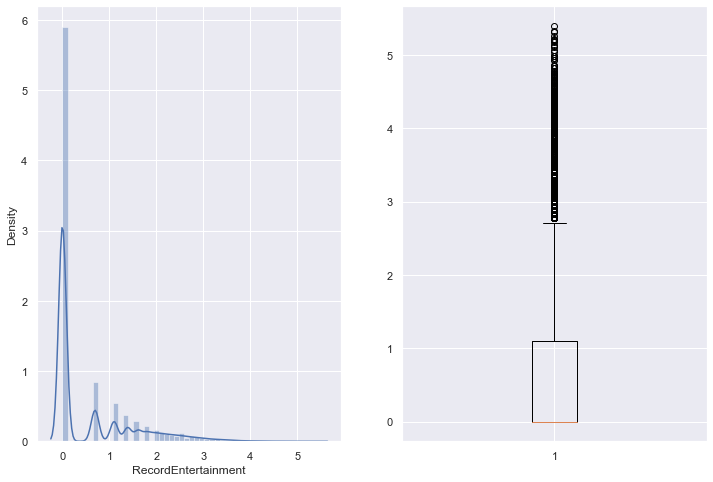


----- RecordLearn -----
count    158981.000000
mean          2.245484
std           1.156521
min           0.000000
25%           1.386294
50%           2.302585
75%           3.091042
max           6.063785
Name: RecordLearn, dtype: float64
* Variance: 1.3375406602944038
* Median: 2.302585092994046
* Skewness: -0.09998235957227893
* Kurtosis: -0.712537005191439
* Percentage of outliers: 0.00010693101691397086
* Number of missing value: 0


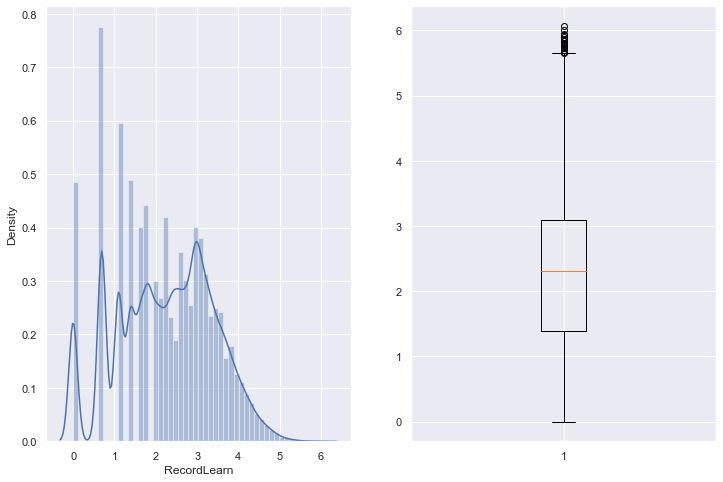


----- UsageTimeDiscovery -----
count    158981.000000
mean          0.658814
std           1.077722
min           0.000000
25%           0.000000
50%           0.000000
75%           1.275363
max           5.818360
Name: UsageTimeDiscovery, dtype: float64
* Variance: 1.1614843446912997
* Median: 0.0
* Skewness: 1.3930481321770956
* Kurtosis: 0.5670109113660735
* Percentage of outliers: 0.03421792541247067
* Number of missing value: 0


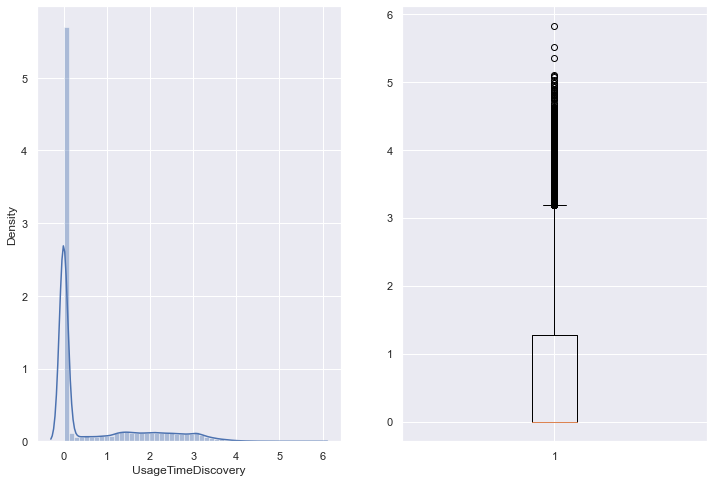


----- UsageTimeEntertainment -----
count    158981.000000
mean          0.643759
std           1.112645
min           0.000000
25%           0.000000
50%           0.000000
75%           0.928219
max           6.057908
Name: UsageTimeEntertainment, dtype: float64
* Variance: 1.2379786785257563
* Median: 0.0
* Skewness: 1.7066184300094955
* Kurtosis: 1.8669038991553966
* Percentage of outliers: 0.1199954711569307
* Number of missing value: 0


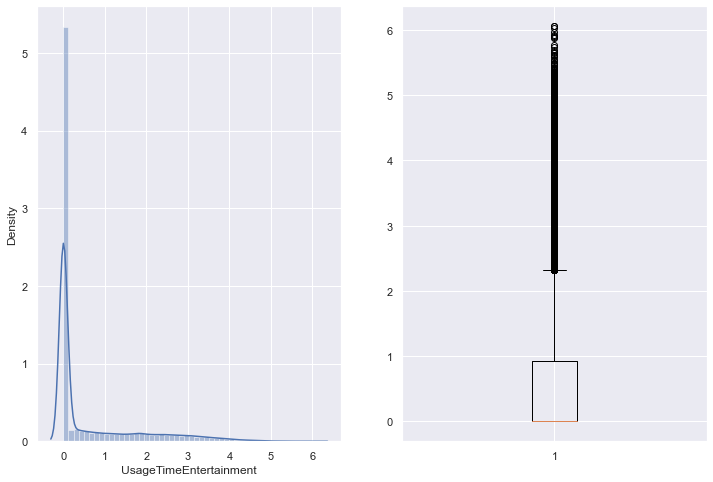


----- UsageTimeLearn -----
count    158981.000000
mean          2.055482
std           1.162421
min           0.000000
25%           1.115142
50%           2.131797
75%           2.931727
max           7.020218
Name: UsageTimeLearn, dtype: float64
* Variance: 1.3512227803676224
* Median: 2.131796772013764
* Skewness: -0.0167219595302974
* Kurtosis: -0.8047423942270049
* Percentage of outliers: 0.00020757197400947283
* Number of missing value: 0


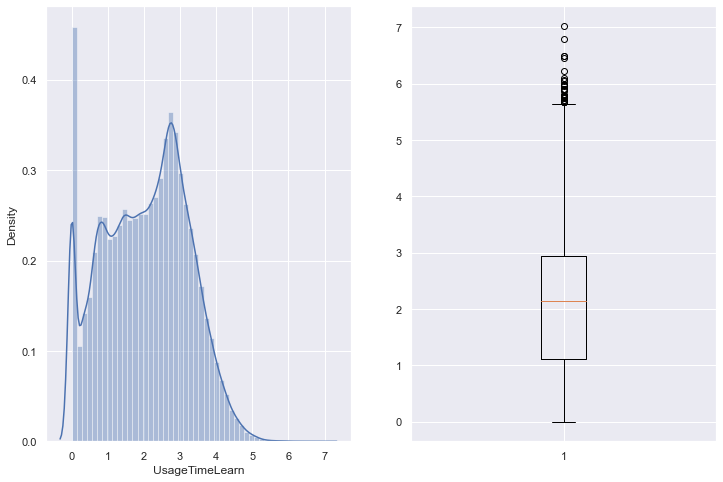


----- MedianUsageTime -----
count    158981.000000
mean          1.877883
std           0.867141
min           0.000000
25%           1.208960
50%           1.915451
75%           2.529322
max           6.095104
Name: MedianUsageTime, dtype: float64
* Variance: 0.7519330801764769
* Median: 1.9154509415706047
* Skewness: 0.010963593861537193
* Kurtosis: -0.6370103030583034
* Percentage of outliers: 0.0006919065800315761
* Number of missing value: 0


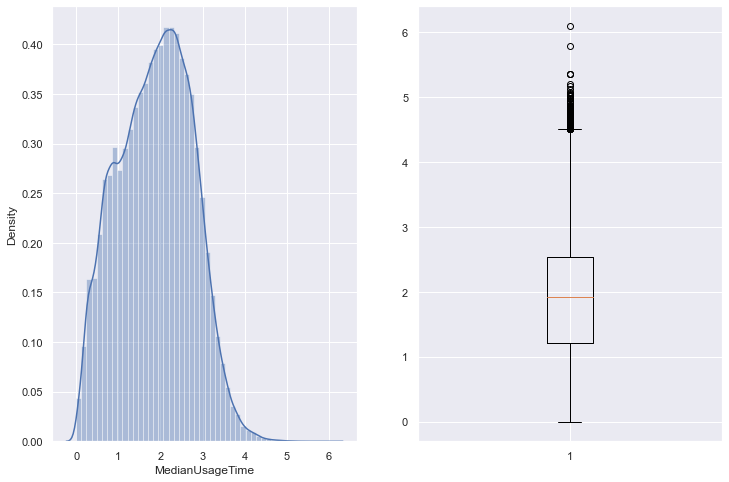


----- MedianRecord -----
count    158981.000000
mean          1.668420
std           0.976040
min           0.000000
25%           1.098612
50%           1.704748
75%           2.397895
max           5.262690
Name: MedianRecord, dtype: float64
* Variance: 0.9526535544278487
* Median: 1.7047480922384253
* Skewness: -0.017865539969934126
* Kurtosis: -0.670330437036581
* Percentage of outliers: 0.0009057686138595178
* Number of missing value: 0


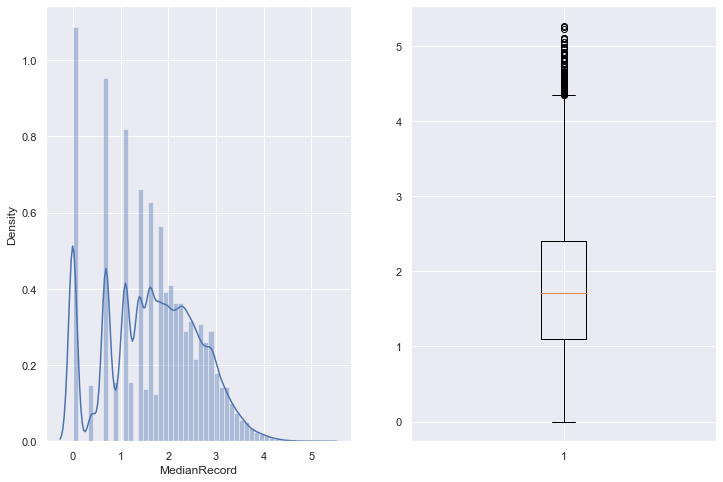


----- MedianPaymentScreen -----
count    158981.000000
mean          0.483489
std           0.697152
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.209486
Name: MedianPaymentScreen, dtype: float64
* Variance: 0.48602105182098876
* Median: 0.0
* Skewness: 1.4285673224573403
* Kurtosis: 1.5715664888185246
* Percentage of outliers: 0.07227278731420736
* Number of missing value: 0


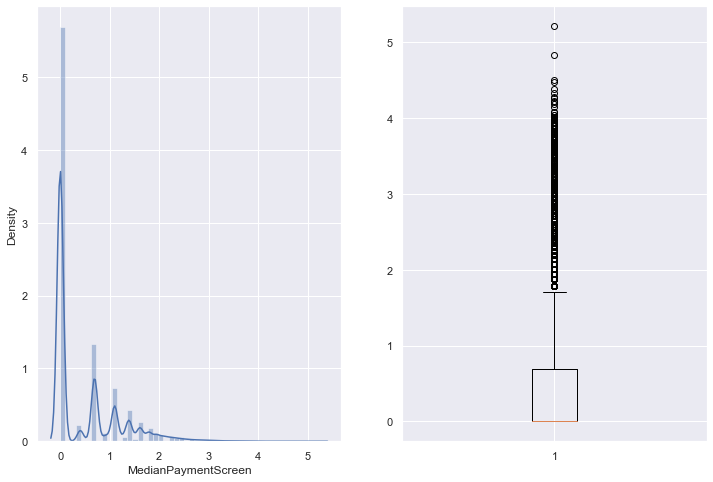


----- AvgTimePerCompletion -----
count    158981.000000
mean          0.669991
std           0.257809
min           0.000000
25%           0.516808
50%           0.625938
75%           0.787922
max           4.224934
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.06646527967773917
* Median: 0.6259384308664954
* Skewness: 1.210342248689603
* Kurtosis: 3.8025228996084492
* Percentage of outliers: 0.046672243853039044
* Number of missing value: 0


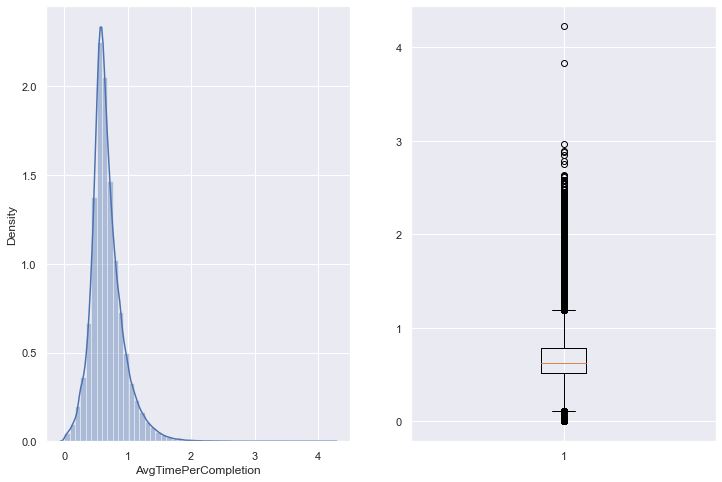


----- InteractionGeneral -----
count    158981.000000
mean          4.714508
std           2.432010
min           0.000000
25%           2.809403
50%           4.955264
75%           6.576470
max          12.731358
Name: InteractionGeneral, dtype: float64
* Variance: 5.914670241046202
* Median: 4.955263518561269
* Skewness: -0.12087207823359727
* Kurtosis: -0.8704138743814958
* Percentage of outliers: 2.5160239273875493e-05
* Number of missing value: 0


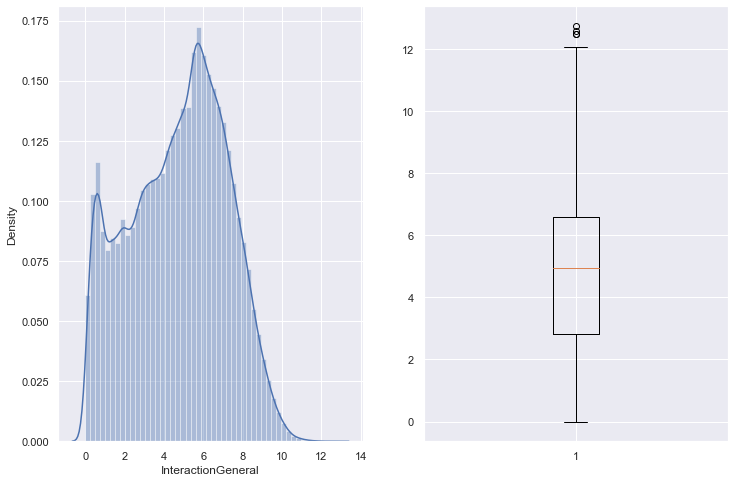


----- InteractionLearn -----
count    158981.000000
mean          4.029906
std           2.463472
min           0.000000
25%           1.934416
50%           4.224203
75%           5.927992
max          12.440142
Name: InteractionLearn, dtype: float64
* Variance: 6.06869639913329
* Median: 4.224202549480315
* Skewness: -0.018227029075790758
* Kurtosis: -0.9712482808446339
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


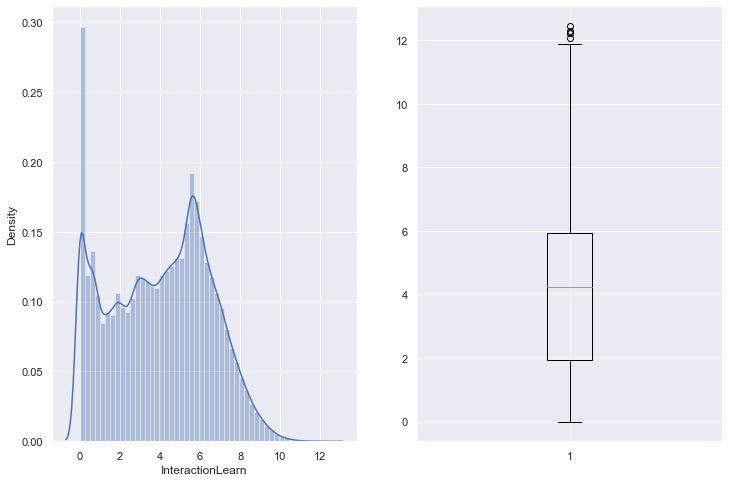


----- InteractionDiscovery -----
count    158981.000000
mean          1.003362
std           1.746340
min           0.000000
25%           0.000000
50%           0.000000
75%           1.427916
max          10.132911
Name: InteractionDiscovery, dtype: float64
* Variance: 3.049702468304741
* Median: 0.0
* Skewness: 1.6438049684532736
* Kurtosis: 1.4953627214209555
* Percentage of outliers: 0.12843673143331594
* Number of missing value: 0


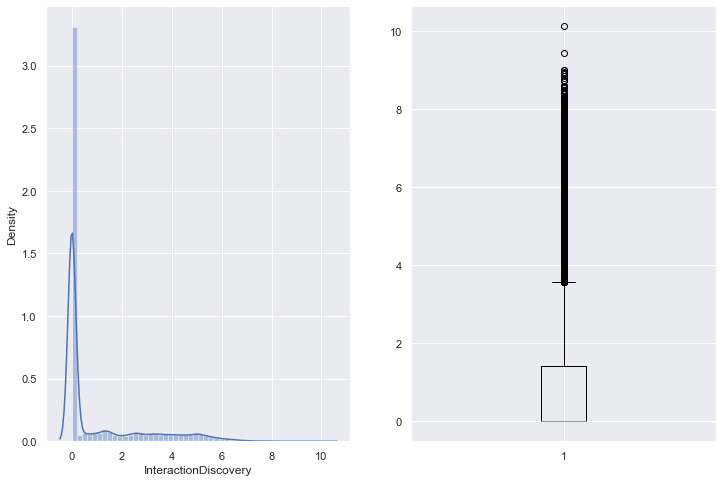


----- InteractionEntertainment -----
count    158981.000000
mean          1.061911
std           1.904856
min           0.000000
25%           0.000000
50%           0.000000
75%           1.386294
max          11.368783
Name: InteractionEntertainment, dtype: float64
* Variance: 3.6284760295642275
* Median: 0.0
* Skewness: 1.8303059839032114
* Kurtosis: 2.4148420903395507
* Percentage of outliers: 0.13978399934583377
* Number of missing value: 0


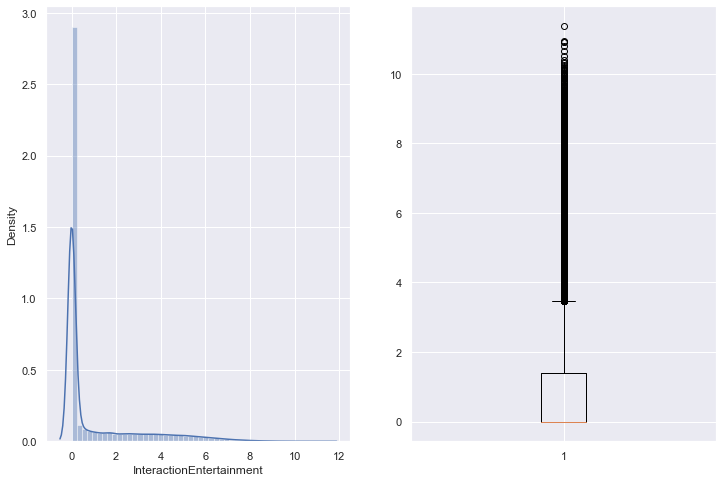


----- MedianInteraction -----
count    158981.000000
mean          3.427440
std           1.813382
min           0.000000
25%           1.987874
50%           3.478158
75%           4.794633
max          10.675204
Name: MedianInteraction, dtype: float64
* Variance: 3.288354496920597
* Median: 3.4781584227982836
* Skewness: 0.06385424705577115
* Kurtosis: -0.7394882807755141
* Percentage of outliers: 0.0003333731703788503
* Number of missing value: 0


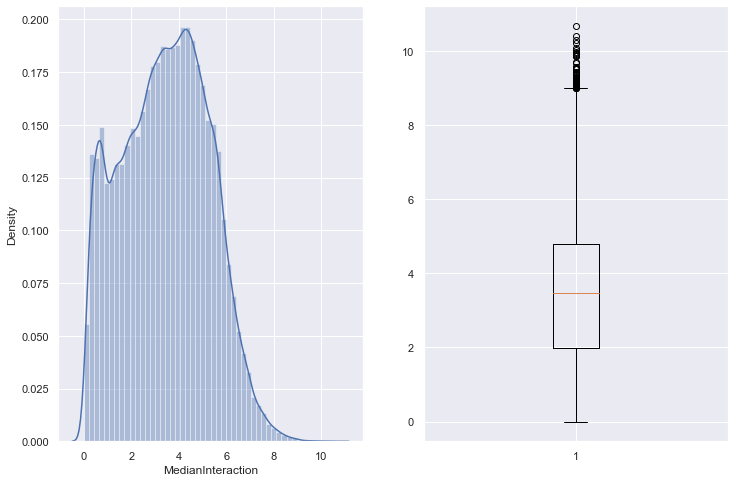

In [56]:
for col in data.columns[1:]:
    if col not in excludes:
        fc.continuous_analysis(data, col)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  float64
 6   ModeFirstHour             158981 non-null  int64  
 7   ModeLastHour              158981 non-null  int64  
 8   ModeLastDay               158981 non-null  int64  
 9   ModeDayofweek             158981 non-null  int64  
 10  ScaleGapday               11223 non-null   object 
 11  TotalChild                158981 non-null  float64
 12  MedianChildAge            158981 non-null  float64
 13  No.Female                 158981 non-null  f

In [58]:
data.to_csv('ICK_Active1Days_v1.csv', index=False)

In [59]:
X = data.drop(['UserID', 'Label', 'firstPaymentType', 'gapday', 'ScaleGapday'], axis = 1)
y = data['Label']

In [60]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [61]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [62]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [167]:
sw = fc.BinarySampleWeights(X_train.shape[0], y_train)
sw_zen = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'zen')
sw_isns = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'isns')
sw_eff = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'ens', beta = 0.99999)

In [64]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9380503836960624

In [65]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.938

* Confusion Matrix: 
[[29607    98]
 [ 1875   217]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29705
           1       0.69      0.10      0.18      2092

    accuracy                           0.94     31797
   macro avg       0.81      0.55      0.57     31797
weighted avg       0.92      0.94      0.92     31797



In [66]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 100,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9203358913070826

In [67]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9152

* Confusion Matrix: 
[[28090  1615]
 [ 1082  1010]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29705
           1       0.38      0.48      0.43      2092

    accuracy                           0.92     31797
   macro avg       0.67      0.71      0.69     31797
weighted avg       0.92      0.92      0.92     31797



In [80]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9573216756824758

In [81]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9253

* Confusion Matrix: 
[[28533  1172]
 [ 1202   890]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29705
           1       0.43      0.43      0.43      2092

    accuracy                           0.93     31797
   macro avg       0.70      0.69      0.69     31797
weighted avg       0.92      0.93      0.93     31797



ROC AUC score: 0.6930


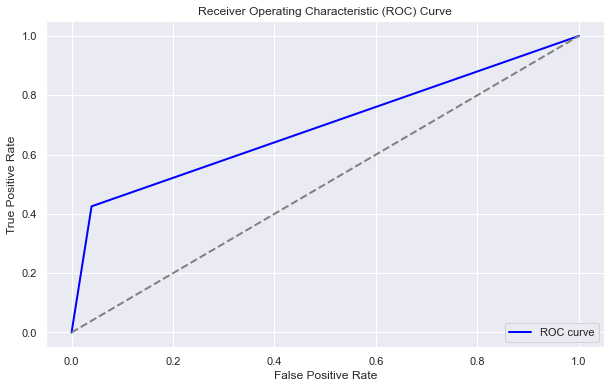

In [82]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [90]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9276638570889421

In [91]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9182

* Confusion Matrix: 
[[28187  1518]
 [ 1084  1008]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29705
           1       0.40      0.48      0.44      2092

    accuracy                           0.92     31797
   macro avg       0.68      0.72      0.70     31797
weighted avg       0.93      0.92      0.92     31797



ROC AUC score: 0.7154


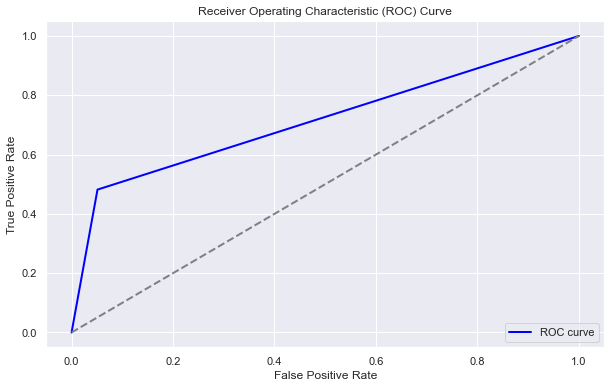

In [92]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [168]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9348974713800478

In [169]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9277

* Confusion Matrix: 
[[28614  1091]
 [ 1207   885]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29705
           1       0.45      0.42      0.44      2092

    accuracy                           0.93     31797
   macro avg       0.70      0.69      0.70     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.6932


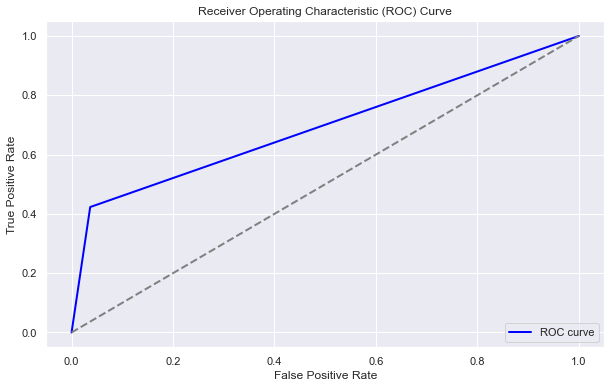

In [130]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [139]:
def plot_precision_recall_curve(model, X, y):
    from sklearn.metrics import precision_recall_curve, auc
    # Get predicted probabilities for positive class
    y_pred = model.predict(X)
    
    # Calculate precision, recall, and threshold values
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    
    # Calculate area under the curve (AUC)
    auc_score = auc(recall, precision)
    
    # Plot precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', label='Precision-Recall curve (AUC = %0.2f)' % auc_score)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


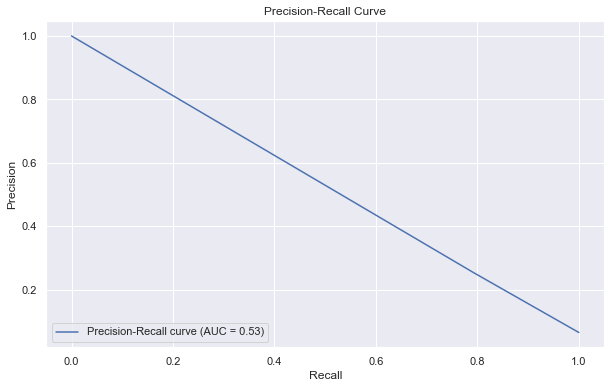

In [140]:
plot_precision_recall_curve(lgbm_model, X_train, y_train)

In [135]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.832392439300541

In [136]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8185

* Confusion Matrix: 
[[24606  5099]
 [  671  1421]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     29705
           1       0.22      0.68      0.33      2092

    accuracy                           0.82     31797
   macro avg       0.60      0.75      0.61     31797
weighted avg       0.92      0.82      0.86     31797



ROC AUC score: 0.7538


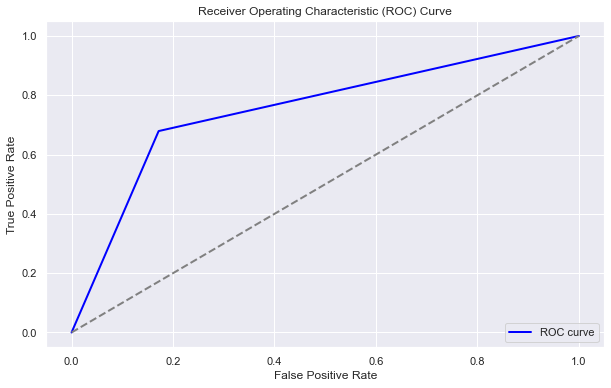

In [137]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

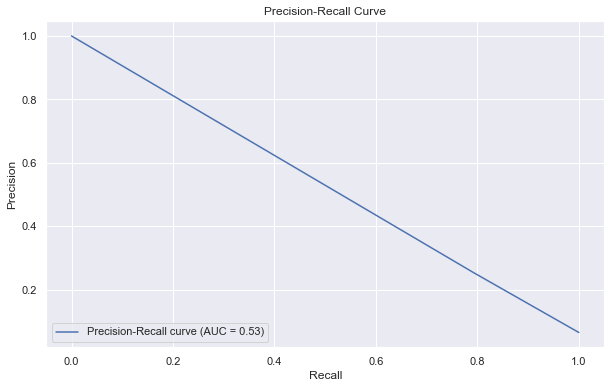

In [141]:
plot_precision_recall_curve(lgbm_model, X_train, y_train)

In [142]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8242782110957353

In [143]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8095

* Confusion Matrix: 
[[24304  5401]
 [  657  1435]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     29705
           1       0.21      0.69      0.32      2092

    accuracy                           0.81     31797
   macro avg       0.59      0.75      0.61     31797
weighted avg       0.92      0.81      0.85     31797



ROC AUC score: 0.7521


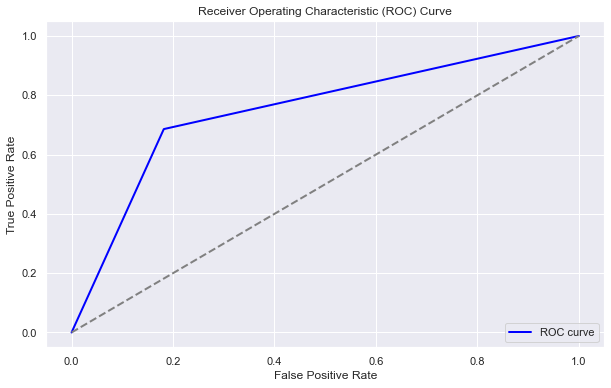

In [144]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

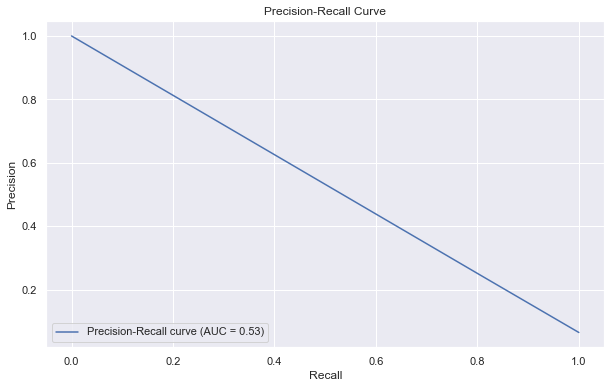

In [145]:
plot_precision_recall_curve(lgbm_model, X_train, y_train)

In [106]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()

gauss_model = gauss.fit(X_train, y_train)
gauss_model.score(X_train, y_train)

0.7806327839979872

In [107]:
fc.eval_clf_testset(gauss_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7789

* Confusion Matrix: 
[[23555  6150]
 [  881  1211]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     29705
           1       0.16      0.58      0.26      2092

    accuracy                           0.78     31797
   macro avg       0.56      0.69      0.56     31797
weighted avg       0.91      0.78      0.83     31797



In [108]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)

tree_clf = tree.fit(X_train, y_train)
tree_clf.score(X_train, y_train)

1.0

In [109]:
fc.eval_clf_testset(tree_clf, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8948

* Confusion Matrix: 
[[27863  1842]
 [ 1502   590]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     29705
           1       0.24      0.28      0.26      2092

    accuracy                           0.89     31797
   macro avg       0.60      0.61      0.60     31797
weighted avg       0.90      0.89      0.90     31797



In [110]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7494496163039376

In [111]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.751

* Confusion Matrix: 
[[22424  7281]
 [  638  1454]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     29705
           1       0.17      0.70      0.27      2092

    accuracy                           0.75     31797
   macro avg       0.57      0.72      0.56     31797
weighted avg       0.92      0.75      0.81     31797



In [112]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7502437413511134

In [113]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7511

* Confusion Matrix: 
[[22427  7278]
 [  635  1457]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     29705
           1       0.17      0.70      0.27      2092

    accuracy                           0.75     31797
   macro avg       0.57      0.73      0.56     31797
weighted avg       0.92      0.75      0.81     31797



In [114]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9245817083909926

In [115]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.924

* Confusion Matrix: 
[[28738   967]
 [ 1451   641]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     29705
           1       0.40      0.31      0.35      2092

    accuracy                           0.92     31797
   macro avg       0.68      0.64      0.65     31797
weighted avg       0.92      0.92      0.92     31797



In [116]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.8467024153981633

In [117]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8478

* Confusion Matrix: 
[[25800  3905]
 [  936  1156]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     29705
           1       0.23      0.55      0.32      2092

    accuracy                           0.85     31797
   macro avg       0.60      0.71      0.62     31797
weighted avg       0.92      0.85      0.88     31797



In [118]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [119]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9042

* Confusion Matrix: 
[[28218  1487]
 [ 1558   534]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29705
           1       0.26      0.26      0.26      2092

    accuracy                           0.90     31797
   macro avg       0.61      0.60      0.60     31797
weighted avg       0.90      0.90      0.90     31797



In [120]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [121]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9064

* Confusion Matrix: 
[[28273  1432]
 [ 1545   547]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29705
           1       0.28      0.26      0.27      2092

    accuracy                           0.91     31797
   macro avg       0.61      0.61      0.61     31797
weighted avg       0.90      0.91      0.91     31797



In [122]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [123]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8998

* Confusion Matrix: 
[[28036  1669]
 [ 1516   576]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     29705
           1       0.26      0.28      0.27      2092

    accuracy                           0.90     31797
   macro avg       0.60      0.61      0.61     31797
weighted avg       0.90      0.90      0.90     31797



In [124]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [125]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9018

* Confusion Matrix: 
[[28140  1565]
 [ 1556   536]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29705
           1       0.26      0.26      0.26      2092

    accuracy                           0.90     31797
   macro avg       0.60      0.60      0.60     31797
weighted avg       0.90      0.90      0.90     31797



In [126]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42, n_estimators = 100)
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999685495030821

In [127]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9416

* Confusion Matrix: 
[[29597   108]
 [ 1748   344]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29705
           1       0.76      0.16      0.27      2092

    accuracy                           0.94     31797
   macro avg       0.85      0.58      0.62     31797
weighted avg       0.93      0.94      0.92     31797



In [146]:
forest = RandomForestClassifier(random_state = 42, n_estimators = 100, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999606868788526

In [147]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9415

* Confusion Matrix: 
[[29630    75]
 [ 1784   308]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29705
           1       0.80      0.15      0.25      2092

    accuracy                           0.94     31797
   macro avg       0.87      0.57      0.61     31797
weighted avg       0.93      0.94      0.92     31797



In [148]:
forest = RandomForestClassifier(random_state = 42, n_estimators = 100, class_weight = {0: sw_isns[0], 1: sw_isns[1]})
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999685495030821

In [149]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9415

* Confusion Matrix: 
[[29620    85]
 [ 1775   317]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29705
           1       0.79      0.15      0.25      2092

    accuracy                           0.94     31797
   macro avg       0.87      0.57      0.61     31797
weighted avg       0.93      0.94      0.92     31797



In [150]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.934016857466348

In [151]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9276

* Confusion Matrix: 
[[28603  1102]
 [ 1199   893]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29705
           1       0.45      0.43      0.44      2092

    accuracy                           0.93     31797
   macro avg       0.70      0.69      0.70     31797
weighted avg       0.93      0.93      0.93     31797



In [152]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [153]:
class_weights_dict = dict(enumerate(class_weights))

In [154]:
class_weights_dict

{0: 0.5352138754788885, 1: 7.599474187380497}

In [155]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = class_weights_dict,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8298685369228834

In [156]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8172

* Confusion Matrix: 
[[24565  5140]
 [  674  1418]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     29705
           1       0.22      0.68      0.33      2092

    accuracy                           0.82     31797
   macro avg       0.59      0.75      0.61     31797
weighted avg       0.92      0.82      0.86     31797



In [157]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.954420367341804

In [158]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9423

* Confusion Matrix: 
[[29494   211]
 [ 1625   467]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29705
           1       0.69      0.22      0.34      2092

    accuracy                           0.94     31797
   macro avg       0.82      0.61      0.65     31797
weighted avg       0.93      0.94      0.93     31797



In [165]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 800,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1319865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=3,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.9266574411875708

In [166]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9176

* Confusion Matrix: 
[[28174  1531]
 [ 1089  1003]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29705
           1       0.40      0.48      0.43      2092

    accuracy                           0.92     31797
   macro avg       0.68      0.71      0.69     31797
weighted avg       0.93      0.92      0.92     31797



ROC AUC score: 0.7098


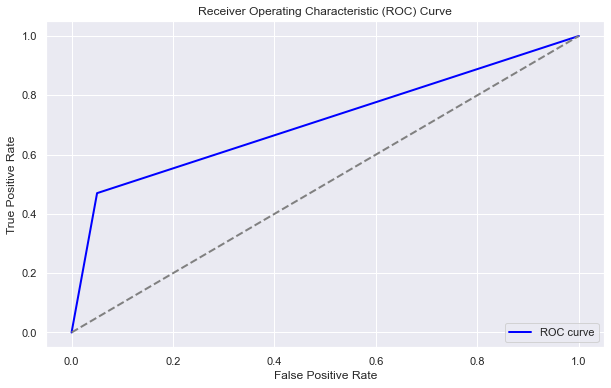

In [164]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [144]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [145]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9896337772397095

In [146]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9806

* Confusion Matrix: 
[[117249   1695]
 [   769   7471]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    118944
           1       0.82      0.91      0.86      8240

    accuracy                           0.98    127184
   macro avg       0.90      0.95      0.92    127184
weighted avg       0.98      0.98      0.98    127184



In [147]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.929

* Confusion Matrix: 
[[28729  1008]
 [ 1248   812]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     29737
           1       0.45      0.39      0.42      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.68      0.69     31797
weighted avg       0.93      0.93      0.93     31797



In [148]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9440114675813829

In [149]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8913

* Confusion Matrix: 
[[27215  2522]
 [  935  1125]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     29737
           1       0.31      0.55      0.39      2060

    accuracy                           0.89     31797
   macro avg       0.64      0.73      0.67     31797
weighted avg       0.92      0.89      0.90     31797



# Model in Original Data

In [152]:
X = data1.drop(['UserID', 'Label', 'firstPaymentType', 'gapday'], axis = 1)
y = data1['Label']

In [153]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [154]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [155]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [156]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9338596049817587

In [157]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9342

* Confusion Matrix: 
[[29650    87]
 [ 2006    54]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.38      0.03      0.05      2060

    accuracy                           0.93     31797
   macro avg       0.66      0.51      0.51     31797
weighted avg       0.90      0.93      0.91     31797



In [158]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.9377437413511134

In [159]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9383

* Confusion Matrix: 
[[29627   110]
 [ 1852   208]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.65      0.10      0.17      2060

    accuracy                           0.94     31797
   macro avg       0.80      0.55      0.57     31797
weighted avg       0.92      0.94      0.92     31797



In [160]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_mm, y_train)

logit_model.score(X_train_mm, y_train)

0.937193357655051

In [161]:
fc.eval_clf_testset(logit_model, X_test_mm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9378

* Confusion Matrix: 
[[29637   100]
 [ 1878   182]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.65      0.09      0.16      2060

    accuracy                           0.94     31797
   macro avg       0.79      0.54      0.56     31797
weighted avg       0.92      0.94      0.92     31797



In [162]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_rb, y_train)

logit_model.score(X_train_rb, y_train)

0.9362183922505976

In [163]:
fc.eval_clf_testset(logit_model, X_test_rb, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9366

* Confusion Matrix: 
[[29615   122]
 [ 1895   165]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.57      0.08      0.14      2060

    accuracy                           0.94     31797
   macro avg       0.76      0.54      0.55     31797
weighted avg       0.92      0.94      0.91     31797



In [164]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 100,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9222386463706127

In [165]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9181

* Confusion Matrix: 
[[28194  1543]
 [ 1060  1000]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.39      0.49      0.43      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.72      0.70     31797
weighted avg       0.93      0.92      0.92     31797



In [166]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 500,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9530365454774186

In [167]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.926

* Confusion Matrix: 
[[28550  1187]
 [ 1165   895]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.43      0.43      0.43      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.70      0.70     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.6973


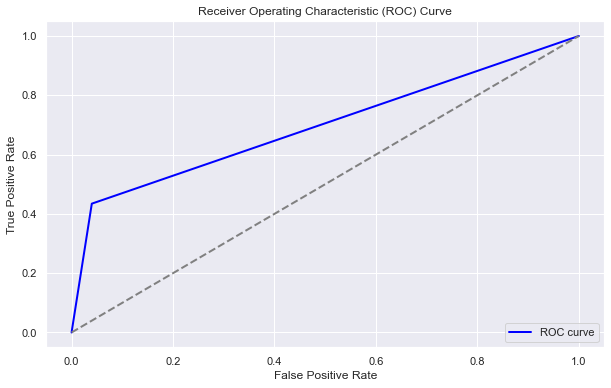

In [168]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [199]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.045,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=5)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9374292363819349

In [200]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9233

* Confusion Matrix: 
[[28403  1334]
 [ 1106   954]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.42      0.46      0.44      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.71      0.70     31797
weighted avg       0.93      0.92      0.93     31797



ROC AUC score: 0.7091


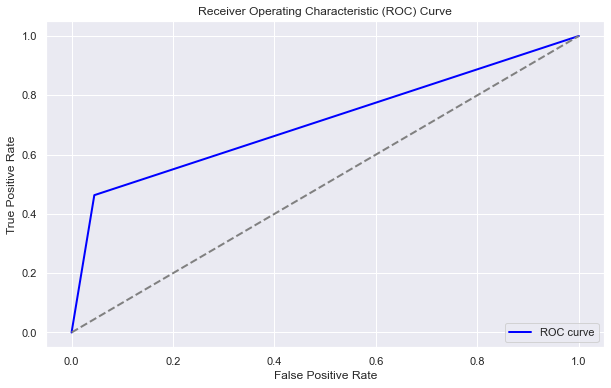

In [201]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))